## Build Medicare Advantage Data (2014-2019)
### Code to build plan and service area data for each year from 2014 to 2019.

In [1]:
from pathlib import Path
import re 
import numpy as np 
import pandas as pd 

# settings
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

# Paths 
BASE = Path("../../..")
OUT_DIR = BASE /"data" / "output"
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [20]:
def _clean_colnames(cols):
    """Standardize column names: lower-case, strip, replace spaces.punct with _."""
    out = []
    for c in cols:
        c2 = re.sub(r"[^0-9a-zA-Z]+", "_", str(c).strip()).strip("_").lower()
        out.append(c2)
    return out


def read_contract(path: Path) -> pd.DataFrame:
    """Read a single monthly Contract Info file."""
    df = pd.read_csv(path, dtype=str, encoding="latin1")
    df.columns = _clean_colnames(df.columns)

    # Harmonize common column-name variants
    ren = {
        "contract_id": "contractid",
        "contract":    "contractid",
        "plan_id":     "planid",
        "plan":        "planid",
        "organization_type": "org_type",
        "plan_type":   "plan_type",
        "offers_part_d": "partd",
        "snp_plan":    "snp",
        "organization_name": "org_name",
        "organization_marketing_name": "org_marketing_name",
        "parent_organization": "parent_org",
        "contract_effective_date": "contract_date",
    }
    df = df.rename(columns={k: v for k, v in ren.items() if k in df.columns})

    if "planid" in df.columns:
        df["planid"] = pd.to_numeric(df["planid"], errors="coerce")

    return df

In [21]:
def read_enroll(path: Path) -> pd.DataFrame:
    """Read a single monthly Enrollment Info file."""
    df = pd.read_csv(path, dtype=str, na_values=["*"], encoding="latin1")
    df.columns = _clean_colnames(df.columns)

    # Harmonize common column-name variants
    ren = {
        "contract_number": "contractid",
        "contract_id":     "contractid",
        "contract":        "contractid",
        "plan_id":         "planid",
        "plan":            "planid",
        "county_name":     "county",
        "state_abbr":      "state",
        "fips_state_county_code": "fips",
        "ssa_state_county_code":  "ssa",
    }
    df = df.rename(columns={k: v for k, v in ren.items() if k in df.columns})

    if "planid" in df.columns:
        df["planid"] = pd.to_numeric(df["planid"], errors="coerce")
    if "fips" in df.columns:
        df["fips"] = pd.to_numeric(df["fips"], errors="coerce")

    return df

In [22]:
def read_service_area(path: Path) -> pd.DataFrame:
    """Read a single monthly service-area file."""
    df = pd.read_csv(path, dtype=str, na_values=["*"], encoding="latin1")
    df.columns = _clean_colnames(df.columns)

    # Harmonize common column-name variants
    ren = {
        "contract_id":        "contractid",
        "organization_name":  "org_name",
        "organization_type":  "org_type",
    }
    df = df.rename(columns={k: v for k, v in ren.items() if k in df.columns})

    # Type fixes
    if "partial" in df.columns:
        df["partial"] = df["partial"].map(
            lambda x: str(x).strip().lower() in {"true", "t", "1", "yes", "y"}
            if pd.notna(x) else np.nan
        )
    for col in ["ssa", "fips"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    return df


def load_month(enroll_dir: Path, m: str, y: int) -> pd.DataFrame:
    """Load contract + enrollment for one month and merge them."""
    c_path = enroll_dir / f"CPSC_Contract_Info_{y}_{m}.csv"
    e_path = enroll_dir / f"CPSC_Enrollment_Info_{y}_{m}.csv"

    contract = read_contract(c_path)

    # Keep one row per (contractid, planid)
    if {"contractid", "planid"}.issubset(contract.columns):
        contract = contract.drop_duplicates(subset=["contractid", "planid"], keep="first")

    enroll = read_enroll(e_path)

    # Merge contract info into enrollment
    if {"contractid", "planid"}.issubset(enroll.columns) and {"contractid", "planid"}.issubset(contract.columns):
        df = enroll.merge(contract, on=["contractid", "planid"], how="left", suffixes=("", "_contract"))
    else:
        df = enroll.copy()

    df["month"] = int(m)
    df["year"]  = int(y)
    return df


def load_month_sa(sa_dir: Path, m: str, y: int) -> pd.DataFrame:
    """Load one month of service-area data."""
    path = sa_dir / f"MA_Cnty_SA_{y}_{m}.csv"
    df   = read_service_area(path)
    df["month"] = int(m)
    df["year"]  = int(y)
    return df

In [23]:
# Building data for one Year
def build_year_ma(year: int) -> pd.DataFrame:
    print(f"\n{'='*60}")
    print(f"Building MA data for year {year}")
    print(f"{'='*60}")
    
    MONTHS = [f"{m:02d}" for m in range(1, 13)]
    
    enroll_dir = BASE / "data" / "input" / f"enrollment_{year}"
    sa_dir = BASE / "data" / "input" / f"service_area_{year}"
    
    if not enroll_dir.exists():
        print(f"ERROR: Enrollment directory not found: {enroll_dir}")
        return pd.DataFrame()
    if not sa_dir.exists():
        print(f"ERROR: Service area directory not found: {sa_dir}")
        return pd.DataFrame()
    
    # Read enrollment data
    print(f"  Reading enrollment data for {year}...")
    plan_year = pd.concat([load_month(enroll_dir, m, year) for m in MONTHS], ignore_index=True)

    sort_cols = [c for c in ["contractid", "planid", "state", "county", "month"] if c in plan_year.columns]
    plan_year = plan_year.sort_values(sort_cols).reset_index(drop=True)
    
    # Fill missing FIPS
    if {"state", "county", "fips"}.issubset(plan_year.columns):
        plan_year["fips"] = (
            plan_year.groupby(["state", "county"], dropna=False)["fips"]
            .transform(lambda s: s.ffill().bfill())
        )
    
    # Fill plan-level descriptors
    fill_cols_planid = [c for c in ["plan_type", "partd", "snp", "eghp", "plan_name"] if c in plan_year.columns]
    if fill_cols_planid and {"contractid", "planid"}.issubset(plan_year.columns):
        plan_year[fill_cols_planid] = (
            plan_year.groupby(["contractid", "planid"], dropna=False)[fill_cols_planid]
            .transform(lambda df: df.ffill().bfill())
        )
# Fill org-level descriptors
    fill_cols_contract = [c for c in ["org_name", "org_marketing_name", "org_type", "parent_org", "contract_date"] 
                          if c in plan_year.columns]
    if fill_cols_contract and "contractid" in plan_year.columns:
        plan_year[fill_cols_contract] = (
            plan_year.groupby(["contractid"], dropna=False)[fill_cols_contract]
            .transform(lambda df: df.ffill().bfill())
        )
    
    # Collapse to one row per (contractid, planid, fips, year)
    group_cols = [c for c in ["contractid", "planid", "fips", "year"] if c in plan_year.columns]
    plan_year = plan_year.sort_values([*group_cols, "month"]).reset_index(drop=True)
    
    carry_cols = [c for c in [
        "state", "county", "org_type", "plan_type", "partd", "snp", "eghp",
        "org_name", "org_marketing_name", "plan_name", "parent_org", "contract_date",
    ] if c in plan_year.columns]
    
    enroll_like = [c for c in plan_year.columns
                   if any(k in c for k in ["enroll", "enrollment", "benefici", "member", "eligible"])]
    carry_cols += [c for c in enroll_like if c not in carry_cols and c not in group_cols and c != "month"]
    
    final_plans = (
        plan_year.groupby(group_cols, dropna=False, as_index=False)
        .agg({c: "last" for c in carry_cols})
    )
    
    print(f"  Plan data: {len(final_plans):,} rows")

    # Read service-area data
    print(f"  Reading service area data for {year}...")
    service_year = pd.concat([load_month_sa(sa_dir, m, year) for m in MONTHS], ignore_index=True)
    
    sort_cols = [c for c in ["contractid", "fips", "state", "county", "month"] if c in service_year.columns]
    service_year = service_year.sort_values(sort_cols).reset_index(drop=True)
    
    # Fill missing fips
    if {"state", "county", "fips"}.issubset(service_year.columns):
        service_year["fips"] = (
            service_year.groupby(["state", "county"], dropna=False)["fips"]
            .transform(lambda s: s.ffill().bfill())
        )
    
    # Fill labels
    fill_cols_sa = [c for c in ["org_name", "org_type", "plan_type", "partial", "eghp", "ssa", "notes"]
                    if c in service_year.columns]
    if fill_cols_sa and "contractid" in service_year.columns:
        service_year[fill_cols_sa] = (
            service_year.groupby(["contractid"], dropna=False)[fill_cols_sa]
            .transform(lambda df: df.ffill().bfill())
        )
    
    # Collapse service area
    group_cols_sa = [c for c in ["contractid", "fips", "year"] if c in service_year.columns]
    service_year = service_year.sort_values([*group_cols_sa, "month"]).reset_index(drop=True)
    
    carry_cols_sa = [c for c in ["state", "county", "org_name", "org_type", "plan_type",
                                  "partial", "eghp", "ssa", "notes"]
                     if c in service_year.columns]
    
    final_service_area = (
        service_year.groupby(group_cols_sa, dropna=False, as_index=False)
        .agg({c: "last" for c in carry_cols_sa})
    )
    
    print(f"  Service area data: {len(final_service_area):,} rows")
    
    # Merge
    print(f"  Merging plan and service area data...")
    merged = final_plans.merge(
        final_service_area,
        on=["contractid", "fips", "year"],
        how="inner",
        suffixes=("_plan", "_sa"),
    )
    
    print(f"  Merged data (before filters): {len(merged):,} rows")
    
    # Apply filters
    planid_num = pd.to_numeric(merged.get("planid"), errors="coerce")
    
    snp_col = "snp" if "snp" in merged.columns else None
    plan_type_col = "plan_type_plan" if "plan_type_plan" in merged.columns else "plan_type"
    
    filtered = merged.copy()
    
    # Remove SNPs
    if snp_col:
        filtered = filtered[filtered[snp_col] == "No"]
        print(f"  After removing SNPs: {len(filtered):,} rows")
    
    # Remove 800-series
    filtered = filtered[(planid_num < 800) | (planid_num >= 900)]
    print(f"  After removing 800-series: {len(filtered):,} rows")
    
    # Remove drug-only plans
    if plan_type_col in filtered.columns:
        filtered["is_pdp_only"] = filtered[plan_type_col].astype(str).str.contains(
            r"(?i)(prescription|^pdp|drug plan)", 
            na=False, 
            regex=True
        ) & ~filtered[plan_type_col].astype(str).str.contains(
            r"(?i)(ma-pd|hmo|ppo|pffs|msa)", 
            na=False, 
            regex=True
        )
        filtered = filtered[~filtered["is_pdp_only"]]
        filtered = filtered.drop(columns=["is_pdp_only"])
        print(f"  After removing drug-only plans: {len(filtered):,} rows")
    
    print(f"  Final filtered data: {len(filtered):,} rows")
    
     # Save to file
    out_path = OUT_DIR / f"ma_data_{year}.csv"
    filtered.to_csv(out_path, index=False)
    print(f"  Saved to: {out_path}")
    
    return filtered

In [24]:
def build_all_years(years: list = [2014, 2015, 2016, 2017, 2018, 2019], save: bool = True):
    results = {}
    
    for year in years:
        try:
            df = build_year_ma(year)
            results[year] = df
        except Exception as e:
            print(f"\n✗ ERROR building data for {year}: {e}")
            results[year] = pd.DataFrame()
    
    print(f"\n{'='*60}")
    print("Summary:")
    print(f"{'='*60}")
    for year, df in results.items():
        status = "✓" if not df.empty else "✗"
        print(f"{status} {year}: {len(df):,} rows")
    
    return results

In [25]:
# To use:
# build_single_year(2018, save=True)  # Build one year
# build_all_years(years=[2014, 2015, 2016, 2017, 2018, 2019], save=True)  # Build all

In [26]:
import os
from pathlib import Path

OUT_DIR = Path("../../../data/output")

print("Files in output directory:")
print("="*60)

if OUT_DIR.exists():
    files = list(OUT_DIR.glob("ma_data_*.csv"))
    if files:
        for f in sorted(files):
            size_mb = f.stat().st_size / (1024 * 1024)
            print(f"✓ {f.name} ({size_mb:.2f} MB)")
    else:
        print("✗ No ma_data_*.csv files found")
else:
    print(f"✗ Directory not found: {OUT_DIR}")

Files in output directory:
✗ No ma_data_*.csv files found


In [27]:
# Call the function to build all years
results = build_all_years(years=[2014, 2015, 2016, 2017, 2018, 2019])


Building MA data for year 2014
  Reading enrollment data for 2014...
  Plan data: 2,533,855 rows
  Reading service area data for 2014...
  Service area data: 397,162 rows
  Merging plan and service area data...
  Merged data (before filters): 1,222,286 rows
  After removing SNPs: 1,211,858 rows
  After removing 800-series: 65,095 rows
  After removing drug-only plans: 65,095 rows
  Final filtered data: 65,095 rows


/var/folders/dr/bz36x93s5vs6lnjjq8z60zfm0000gp/T/ipykernel_69427/1863573618.py:132: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered = filtered[(planid_num < 800) | (planid_num >= 900)]
/var/folders/dr/bz36x93s5vs6lnjjq8z60zfm0000gp/T/ipykernel_69427/1863573618.py:137: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filtered["is_pdp_only"] = filtered[plan_type_col].astype(str).str.contains(
/var/folders/dr/bz36x93s5vs6lnjjq8z60zfm0000gp/T/ipykernel_69427/1863573618.py:141: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  ) & ~filtered[plan_type_col].astype(str).str.contains(


  Saved to: ../../../data/output/ma_data_2014.csv

Building MA data for year 2015
  Reading enrollment data for 2015...
  Plan data: 2,388,316 rows
  Reading service area data for 2015...
  Service area data: 377,761 rows
  Merging plan and service area data...
  Merged data (before filters): 1,213,247 rows
  After removing SNPs: 1,202,216 rows
  After removing 800-series: 67,505 rows
  After removing drug-only plans: 67,505 rows
  Final filtered data: 67,505 rows


/var/folders/dr/bz36x93s5vs6lnjjq8z60zfm0000gp/T/ipykernel_69427/1863573618.py:132: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered = filtered[(planid_num < 800) | (planid_num >= 900)]
/var/folders/dr/bz36x93s5vs6lnjjq8z60zfm0000gp/T/ipykernel_69427/1863573618.py:137: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filtered["is_pdp_only"] = filtered[plan_type_col].astype(str).str.contains(
/var/folders/dr/bz36x93s5vs6lnjjq8z60zfm0000gp/T/ipykernel_69427/1863573618.py:141: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  ) & ~filtered[plan_type_col].astype(str).str.contains(


  Saved to: ../../../data/output/ma_data_2015.csv

Building MA data for year 2016
  Reading enrollment data for 2016...
  Plan data: 2,154,444 rows
  Reading service area data for 2016...
  Service area data: 324,663 rows
  Merging plan and service area data...
  Merged data (before filters): 1,059,738 rows
  After removing SNPs: 1,047,344 rows
  After removing 800-series: 70,772 rows
  After removing drug-only plans: 70,772 rows
  Final filtered data: 70,772 rows


/var/folders/dr/bz36x93s5vs6lnjjq8z60zfm0000gp/T/ipykernel_69427/1863573618.py:132: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered = filtered[(planid_num < 800) | (planid_num >= 900)]
/var/folders/dr/bz36x93s5vs6lnjjq8z60zfm0000gp/T/ipykernel_69427/1863573618.py:137: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filtered["is_pdp_only"] = filtered[plan_type_col].astype(str).str.contains(
/var/folders/dr/bz36x93s5vs6lnjjq8z60zfm0000gp/T/ipykernel_69427/1863573618.py:141: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  ) & ~filtered[plan_type_col].astype(str).str.contains(


  Saved to: ../../../data/output/ma_data_2016.csv

Building MA data for year 2017
  Reading enrollment data for 2017...
  Plan data: 2,250,310 rows
  Reading service area data for 2017...
  Service area data: 320,202 rows
  Merging plan and service area data...
  Merged data (before filters): 1,219,685 rows
  After removing SNPs: 1,206,986 rows
  After removing 800-series: 72,733 rows
  After removing drug-only plans: 72,733 rows
  Final filtered data: 72,733 rows


/var/folders/dr/bz36x93s5vs6lnjjq8z60zfm0000gp/T/ipykernel_69427/1863573618.py:132: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered = filtered[(planid_num < 800) | (planid_num >= 900)]
/var/folders/dr/bz36x93s5vs6lnjjq8z60zfm0000gp/T/ipykernel_69427/1863573618.py:137: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filtered["is_pdp_only"] = filtered[plan_type_col].astype(str).str.contains(
/var/folders/dr/bz36x93s5vs6lnjjq8z60zfm0000gp/T/ipykernel_69427/1863573618.py:141: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  ) & ~filtered[plan_type_col].astype(str).str.contains(


  Saved to: ../../../data/output/ma_data_2017.csv

Building MA data for year 2018
  Reading enrollment data for 2018...
  Plan data: 2,475,109 rows
  Reading service area data for 2018...
  Service area data: 331,593 rows
  Merging plan and service area data...
  Merged data (before filters): 1,366,535 rows
  After removing SNPs: 1,350,940 rows
  After removing 800-series: 87,708 rows
  After removing drug-only plans: 87,708 rows
  Final filtered data: 87,708 rows


/var/folders/dr/bz36x93s5vs6lnjjq8z60zfm0000gp/T/ipykernel_69427/1863573618.py:132: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered = filtered[(planid_num < 800) | (planid_num >= 900)]
/var/folders/dr/bz36x93s5vs6lnjjq8z60zfm0000gp/T/ipykernel_69427/1863573618.py:137: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filtered["is_pdp_only"] = filtered[plan_type_col].astype(str).str.contains(
/var/folders/dr/bz36x93s5vs6lnjjq8z60zfm0000gp/T/ipykernel_69427/1863573618.py:141: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  ) & ~filtered[plan_type_col].astype(str).str.contains(


  Saved to: ../../../data/output/ma_data_2018.csv

Building MA data for year 2019
  Reading enrollment data for 2019...
  Plan data: 2,875,213 rows
  Reading service area data for 2019...
  Service area data: 345,827 rows
  Merging plan and service area data...
  Merged data (before filters): 1,693,175 rows
  After removing SNPs: 1,675,403 rows
  After removing 800-series: 97,772 rows


/var/folders/dr/bz36x93s5vs6lnjjq8z60zfm0000gp/T/ipykernel_69427/1863573618.py:132: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered = filtered[(planid_num < 800) | (planid_num >= 900)]
/var/folders/dr/bz36x93s5vs6lnjjq8z60zfm0000gp/T/ipykernel_69427/1863573618.py:137: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filtered["is_pdp_only"] = filtered[plan_type_col].astype(str).str.contains(
/var/folders/dr/bz36x93s5vs6lnjjq8z60zfm0000gp/T/ipykernel_69427/1863573618.py:141: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  ) & ~filtered[plan_type_col].astype(str).str.contains(


  After removing drug-only plans: 97,772 rows
  Final filtered data: 97,772 rows
  Saved to: ../../../data/output/ma_data_2019.csv

Summary:
✓ 2014: 65,095 rows
✓ 2015: 67,505 rows
✓ 2016: 70,772 rows
✓ 2017: 72,733 rows
✓ 2018: 87,708 rows
✓ 2019: 97,772 rows


/var/folders/dr/bz36x93s5vs6lnjjq8z60zfm0000gp/T/ipykernel_91798/603916579.py:8: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"../../../data/output/ma_data_{year}.csv")
/var/folders/dr/bz36x93s5vs6lnjjq8z60zfm0000gp/T/ipykernel_91798/603916579.py:8: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"../../../data/output/ma_data_{year}.csv")
/var/folders/dr/bz36x93s5vs6lnjjq8z60zfm0000gp/T/ipykernel_91798/603916579.py:8: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"../../../data/output/ma_data_{year}.csv")
/var/folders/dr/bz36x93s5vs6lnjjq8z60zfm0000gp/T/ipykernel_91798/603916579.py:8: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"../../../data/output/ma_data_{year}.csv")


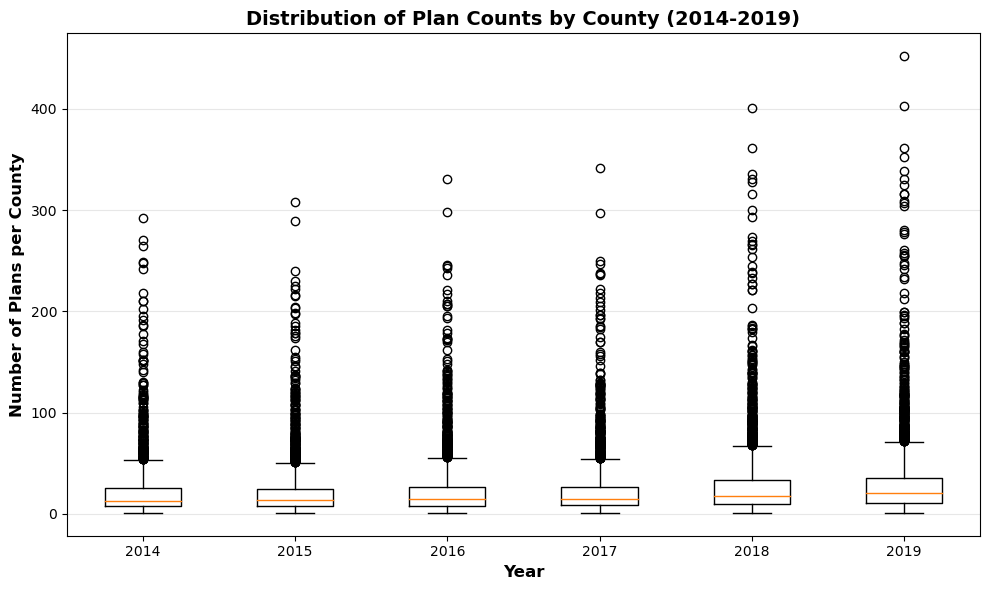

Plot saved!


In [2]:
# Box and Whisker Plot 
import pandas as pd
import matplotlib.pyplot as plt

# Load data
plan_data_list = []
for year in range(2014, 2020):
    df = pd.read_csv(f"../../../data/output/ma_data_{year}.csv")
    df['year'] = year
    plan_data_list.append(df)

all_plans = pd.concat(plan_data_list, ignore_index=True)

# Count plans by county and year
plan_counts = all_plans.groupby(['fips', 'year']).size().reset_index(name='plan_count')

# Create boxplot
fig, ax = plt.subplots(figsize=(10, 6))

data_by_year = [plan_counts[plan_counts['year'] == year]['plan_count'].values 
                for year in range(2014, 2020)]

ax.boxplot(data_by_year, labels=['2014', '2015', '2016', '2017', '2018', '2019'])

ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Plans per County', fontsize=12, fontweight='bold')
ax.set_title('Distribution of Plan Counts by County (2014-2019)', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig("../../../data/output/question1_plan_counts_boxplot.png", dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved!")